In [10]:
#!/usr/bin/env python3
import sys
sys.path.append('eucalc_directory')  # adjust as needed so Python can find eucalc
import eucalc as ec
import os
import numpy as np
from PIL import Image
from scipy.ndimage import label
from joblib import Parallel, delayed

# ─── Parameters ─────────────────────────────────────────────────────────────
datafolder = '.'                   # Folder containing .gif files
k = 360 * 4                         # Number of directions
xinterval = (-1.5, 1.5)
xpoints = 3000

# ─── Utility Functions ────────────────────────────────────────────────────────
def filter_to_largest_cc(img_array):
    """
    Return a binary mask of the largest connected component in img_array.
    """
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num == 0:
        return np.zeros_like(img_array)
    sizes = np.bincount(labeled.ravel())
    if len(sizes) <= 1:
        return np.zeros_like(img_array)
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(img_array.dtype)


def normalize_cc_size(mask, target_area):
    """
    Scale the binary mask so its white connected component has area = target_area.
    """
    current_area = mask.sum()
    if current_area == 0 or current_area == target_area:
        return mask
    scale = np.sqrt(target_area / current_area)
    h, w = mask.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    pil_img = Image.fromarray((mask * 255).astype(np.uint8))
    pil_resized = pil_img.resize((new_w, new_h), resample=Image.BILINEAR)
    new_mask = np.array(pil_resized) > 127
    return new_mask.astype(mask.dtype)


def pad_image_to_square(img_array, target_length):
    """
    Pad and center the image by its white-pixel centroid into a square of side target_length.
    """
    h, w = img_array.shape
    whites = np.argwhere(img_array > 0)
    centroid = whites.mean(axis=0) if whites.size else np.array([h/2.0, w/2.0])
    center = np.array([target_length/2.0, target_length/2.0])
    offset = np.round(center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    pr, pc = offset
    dr0, dc0 = max(0, pr), max(0, pc)
    dr1 = min(target_length, pr + h)
    dc1 = min(target_length, pc + w)
    sr0 = max(0, -pr)
    sc0 = max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img


def compute_curve_range(img, k=k, xinterval=xinterval, xpoints=xpoints):
    """
    Compute the ECT curve for all k directions and return an array of tuples (max, min) per direction.
    """
    cplx = ec.EmbeddedComplex(img)
    cplx.preproc_ect()
    thetas = np.linspace(0, 2*np.pi, k, endpoint=False)
    T = np.linspace(xinterval[0], xinterval[1], xpoints)
    ranges = np.empty((k, 2), dtype=float)
    for i, theta in enumerate(thetas):
        direction = np.array((np.sin(theta), np.cos(theta)))
        ect_dir = cplx.compute_euler_characteristic_transform(direction)
        values = np.array([ect_dir.evaluate(t) for t in T])
        ranges[i, 0] = values.max()
        ranges[i, 1] = values.min()
    return ranges


def process_file_range(fname, target_area, target_length):
    """
    Load, preprocess, compute and return the per-direction ECT curve range tuples for one image.
    """
    path = os.path.join(datafolder, fname)
    img = np.array(Image.open(path))
    if img.ndim == 3:
        img = img.mean(axis=2).astype(img.dtype)
    mask = filter_to_largest_cc(img)
    norm = normalize_cc_size(mask, target_area)
    padded = pad_image_to_square(norm, target_length)
    return compute_curve_range(padded)


def main():
    """
    Loop over all .gif shapes, compute range tuples in parallel per direction,
    report per-image stats and overall global extremes with image and direction.
    """
    files = [f for f in os.listdir(datafolder) if f.lower().endswith('.gif')]
    if not files:
        raise RuntimeError(f"No GIF files found in {datafolder}")

    # Determine global parameters
    areas, dims = [], []
    for f in files:
        img = np.array(Image.open(os.path.join(datafolder, f)))
        if img.ndim == 3:
            img = img.mean(axis=2).astype(img.dtype)
        mask = filter_to_largest_cc(img)
        areas.append(mask.sum())
        w, h = Image.open(os.path.join(datafolder, f)).size
        dims.append(max(w, h))
    target_area = max(areas)
    target_length = max(dims) + 10

    # Parallel compute
    print(f"Computing curve ranges for {len(files)} images in parallel…")
    ranges_list = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_file_range)(f, target_area, target_length)
        for f in files
    )

    # Per-image stats
    per_image_info = []  # (fname, max_val, max_dir, min_val, min_dir)
    for fname, ranges in zip(files, ranges_list):
        max_idx = int(np.argmax(ranges[:, 0]))
        min_idx = int(np.argmin(ranges[:, 1]))
        max_val = ranges[max_idx, 0]
        min_val = ranges[min_idx, 1]
        per_image_info.append((fname, max_val, max_idx, min_val, min_idx))

    # Global extremes
    global_max_entry = max(per_image_info, key=lambda x: x[1])
    global_min_entry = min(per_image_info, key=lambda x: x[3])
    thetas = np.linspace(0, 2*np.pi, k, endpoint=False)
    print("\nGlobal maximum curve value:")
    print(f"  Image: {global_max_entry[0]}, Direction: {thetas[global_max_entry[2]]}, Value: {global_max_entry[1]:.4f}")
    print("Global minimum curve value:")
    print(f"  Image: {global_min_entry[0]}, Direction: {thetas[global_min_entry[4]]}, Value: {global_min_entry[3]:.4f}")

    return per_image_info, global_max_entry, global_min_entry

if __name__ == '__main__':
    main()

Computing curve ranges for 1400 images in parallel…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  6.0min



Global maximum curve value:
  Image: Bone-11.gif, Direction: 4.118977034706618, Value: 251.0000
Global minimum curve value:
  Image: children-3.gif, Direction: 0.0, Value: 0.0000


[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  7.4min finished


## euimage without normalizing size

In [ ]:
#!/usr/bin/env python3
import sys
sys.path.append('eucalc_directory')  # adjust as needed so Python can find eucalc
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label
from joblib import Parallel, delayed

# ─── Settings ─────────────────────────────────────────────────────────────────
datafolder = "."                        # where your .gif files live
k          = 720 * 4
xinterval  = (-1.5, 1.5)
xpoints    = 30000
yinterval  = (0,10)
ypoints    = 10
top_k      = 40

# ─── Utility Functions ────────────────────────────────────────────────────────
def filter_to_largest_cc(img_array):
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num == 0:
        return np.zeros_like(img_array)
    sizes = np.bincount(labeled.ravel())
    if len(sizes) <= 1:
        return np.zeros_like(img_array)
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(img_array.dtype)

def pad_image_to_square(img_array, target_length):
    h, w = img_array.shape
    whites = np.argwhere(img_array > 0)
    centroid = whites.mean(axis=0) if whites.size else np.array([h/2.0, w/2.0])
    center   = np.array([target_length/2.0, target_length/2.0])
    offset   = np.round(center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    pr, pc  = offset
    dr0, dc0 = max(0, pr), max(0, pc)
    dr1 = min(target_length, pr + h)
    dc1 = min(target_length, pc + w)
    sr0 = max(0, -pr)
    sc0 = max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img

# ─── EctImg Class (2D Output) ─────────────────────────────────────────────────
class EctImg:
    def __init__(self, nm, img,
                 k=20,
                 xinterval=(-1.,1.), xpoints=100,
                 yinterval=(-1.,1.), ypoints=100):
        self.nm        = nm
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints   = xpoints
        self.ypoints   = ypoints
        self.image     = self.compute(img, k,
                                      xinterval, xpoints,
                                      yinterval, ypoints)

    def compute(self, img, k,
                xinterval, xpoints,
                yinterval, ypoints):
        cplx   = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2*np.pi, k+1)
        ect1   = np.empty((k, xpoints), dtype=float)
        for i, theta in enumerate(thetas[:-1]):
            direction   = np.array((np.sin(theta), np.cos(theta)))
            ect_dir     = cplx.compute_euler_characteristic_transform(direction)
            T           = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i, :]  = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvals  = np.linspace(yinterval[0], yinterval[1], ypoints+1)
        for col in range(xpoints):
            column = ect1[:, col]
            for row in range(ypoints):
                if row < ypoints-1:
                    mask = (yvals[row] <= column) & (column < yvals[row+1])
                else:
                    mask = (yvals[row] <= column) & (column <= yvals[row+1])
                image[row, col] = mask.sum() / k
        return image

    def plot(self):
        plt.figure(figsize=(10, 8))
        plt.imshow(self.image,
                   aspect='auto',
                   extent=[*self.xinterval, *self.yinterval],
                   origin='lower',
                   interpolation='none')
        plt.colorbar(label='Density')
        plt.title(f'ECT Image: {self.nm}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# ─── Parallel Processing ───────────────────────────────────────────────────────
def process_gif(fname, cat, datafolder,
                k, xinterval, xpoints,
                yinterval, ypoints, target_length):
    arr = np.array(Image.open(os.path.join(datafolder, fname)))
    if arr.ndim == 3:
        arr = arr.mean(axis=2).astype(arr.dtype)
    filt = filter_to_largest_cc(arr)
    pad  = pad_image_to_square(filt, target_length)
    ect2d = EctImg(fname, pad, k,
                   xinterval, xpoints,
                   yinterval, ypoints)
    return ect2d.image.flatten(), cat


def compute_distance_matrix_l2_parallel(feats, n_jobs=-1, verbose=5):
    def compute_row_l2(i, feats):
        diffs = feats - feats[i]
        return i, np.linalg.norm(diffs, axis=1)
    print("Starting parallel distance computation…")
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(compute_row_l2)(i, feats)
        for i in range(feats.shape[0])
    )
    N = feats.shape[0]
    D = np.zeros((N, N), dtype=float)
    for i, row in results:
        D[i, :] = row
    print("Distance computation complete.")
    return D

# ─── Main Pipeline ────────────────────────────────────────────────────────────

def main():
    # 1) Find all GIFs and compute global pad size
    names = [f for f in os.listdir(datafolder) if f.lower().endswith('.gif')]
    if not names:
        print("No GIF files found in", datafolder)
        return
    max_dim = 0
    for fname in names:
        w, h = Image.open(os.path.join(datafolder, fname)).size
        max_dim = max(max_dim, w, h)
    target_length = max_dim + 10
    print("Global target length:", target_length)

    # 2) Group by category
    files_by_cat = {}
    for f in names:
        parts = f.split('-')
        if len(parts) < 2:
            continue
        cat, num = parts[0], parts[1].split('.')[0]
        try:
            num = int(num)
        except ValueError:
            pass
        files_by_cat.setdefault(cat, []).append((num, f))
    for cat in files_by_cat:
        files_by_cat[cat].sort(key=lambda x: x[0])
    sorted_cats = sorted(files_by_cat.keys())

    # 3) Parallel ECT-image computation
    tasks = [(fname, cat) for cat in sorted_cats for _, fname in files_by_cat[cat]]
    print(f"Computing ECT for {len(tasks)} images in parallel…")
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_gif)(fname, cat, datafolder,
                             k, xinterval, xpoints,
                             yinterval, ypoints, target_length)
        for fname, cat in tasks
    )
    features, labels_all = zip(*results)
    features = np.vstack(features)
    labels_all = list(labels_all)

    # 4) Parallel L2 distance matrix
    D = compute_distance_matrix_l2_parallel(features, n_jobs=-1, verbose=10)

    # 5) Bulls-Eye Retrieval Rate
    categories = np.array(labels_all)
    uniq, counts = np.unique(categories, return_counts=True)
    if uniq.size == 0:
        raise RuntimeError("No images found – check datafolder.")
    if not np.all(counts == counts[0]):
        print("Warning: non-uniform class sizes; using min count for M.")
    M = counts.min()
    N = len(categories)
    total_hits = 0
    for i in range(N):
        nearest = np.argsort(D[i])[:top_k]
        total_hits += np.sum(categories[nearest] == categories[i])
    bulls_eye_rate = total_hits / (N * M)
    print(f"\nBull’s-Eye Retrieval Rate: {bulls_eye_rate:.4f} ({bulls_eye_rate*100:.2f}%)")

if __name__ == "__main__":
    main()


Global target length: 1126
Computing ECT for 1400 images in parallel…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  7.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Starting parallel distance computation…


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    5.9s
[Paralle

Distance computation complete.

Bull’s-Eye Retrieval Rate: 0.5403 (54.02%)


## euimage with normalizing size

In [1]:
#!/usr/bin/env python3
import sys
sys.path.append('eucalc_directory')  # adjust as needed so Python can find eucalc
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label
from joblib import Parallel, delayed

# ─── Settings ─────────────────────────────────────────────────────────────────
datafolder = "."                        # where your .gif files live
k          = 720 * 4
xinterval  = (-1.5, 1.5)
xpoints    = 3000
yinterval  = (0, 252)
ypoints    = 252
top_k      = 40

# ─── Utility Functions ────────────────────────────────────────────────────────

def filter_to_largest_cc(img_array):
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num == 0:
        return np.zeros_like(img_array)
    sizes = np.bincount(labeled.ravel())
    if len(sizes) <= 1:
        return np.zeros_like(img_array)
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(img_array.dtype)


def normalize_cc_size(mask, target_area):
    """
    Scale the binary mask so its white connected component has area = target_area.
    """
    current_area = mask.sum()
    if current_area == 0:
        return mask
    scale = np.sqrt(target_area / current_area)
    h, w = mask.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    # Use PIL to resize, then threshold
    pil_img = Image.fromarray((mask * 255).astype(np.uint8))
    pil_resized = pil_img.resize((new_w, new_h), resample=Image.BILINEAR)
    new_mask = np.array(pil_resized) > 127
    return new_mask.astype(mask.dtype)


def pad_image_to_square(img_array, target_length):
    h, w = img_array.shape
    whites = np.argwhere(img_array > 0)
    centroid = whites.mean(axis=0) if whites.size else np.array([h/2.0, w/2.0])
    center   = np.array([target_length/2.0, target_length/2.0])
    offset   = np.round(center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    pr, pc  = offset
    dr0, dc0 = max(0, pr), max(0, pc)
    dr1 = min(target_length, pr + h)
    dc1 = min(target_length, pc + w)
    sr0 = max(0, -pr)
    sc0 = max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img

# ─── EctImg Class (2D Output) ─────────────────────────────────────────────────
class EctImg:
    def __init__(self, nm, img,
                 k=20,
                 xinterval=(-1.,1.), xpoints=100,
                 yinterval=(-1.,1.), ypoints=100):
        self.nm        = nm
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints   = xpoints
        self.ypoints   = ypoints
        self.image     = self.compute(img, k,
                                      xinterval, xpoints,
                                      yinterval, ypoints)

    def compute(self, img, k,
                xinterval, xpoints,
                yinterval, ypoints):
        cplx   = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2*np.pi, k+1)
        ect1   = np.empty((k, xpoints), dtype=float)
        for i, theta in enumerate(thetas[:-1]):
            direction   = np.array((np.sin(theta), np.cos(theta)))
            ect_dir     = cplx.compute_euler_characteristic_transform(direction)
            T           = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i, :]  = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvals  = np.linspace(yinterval[0], yinterval[1], ypoints+1)
        for col in range(xpoints):
            column = ect1[:, col]
            for row in range(ypoints):
                if row < ypoints-1:
                    mask = (yvals[row] <= column) & (column < yvals[row+1])
                else:
                    mask = (yvals[row] <= column) & (column <= yvals[row+1])
                image[row, col] = mask.sum() / k
        return image

    def plot(self):
        plt.figure(figsize=(10, 8))
        plt.imshow(self.image,
                   aspect='auto',
                   extent=[*self.xinterval, *self.yinterval],
                   origin='lower',
                   interpolation='none')
        plt.colorbar(label='Density')
        plt.title(f'ECT Image: {self.nm}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# ─── Parallel Processing ───────────────────────────────────────────────────────
def process_gif(fname, cat, datafolder,
                k, xinterval, xpoints,
                yinterval, ypoints, target_length, target_area):
    arr = np.array(Image.open(os.path.join(datafolder, fname)))
    if arr.ndim == 3:
        arr = arr.mean(axis=2).astype(arr.dtype)
    filt = filter_to_largest_cc(arr)
    norm = normalize_cc_size(filt, target_area)
    pad  = pad_image_to_square(norm, target_length)
    ect2d = EctImg(fname, pad, k,
                   xinterval, xpoints,
                   yinterval, ypoints)
    return ect2d.image.flatten(), cat


def compute_distance_matrix_l2_parallel(feats, n_jobs=-1, verbose=5):
    def compute_row_l2(i, feats):
        diffs = feats - feats[i]
        return i, np.linalg.norm(diffs, axis=1)
    print("Starting parallel distance computation…")
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(compute_row_l2)(i, feats)
        for i in range(feats.shape[0])
    )
    N = feats.shape[0]
    D = np.zeros((N, N), dtype=float)
    for i, row in results:
        D[i, :] = row
    print("Distance computation complete.")
    return D

# ─── Main Pipeline ────────────────────────────────────────────────────────────
def main():
    # 1) Find all GIFs
    names = [f for f in os.listdir(datafolder) if f.lower().endswith('.gif')]
    if not names:
        print("No GIF files found in", datafolder)
        return

    # 2) Compute global pad size and target CC area
    max_dim = 0
    max_area = 0
    for fname in names:
        path = os.path.join(datafolder, fname)
        w, h = Image.open(path).size
        max_dim = max(max_dim, w, h)
        arr = np.array(Image.open(path))
        if arr.ndim == 3:
            arr = arr.mean(axis=2).astype(arr.dtype)
        mask = filter_to_largest_cc(arr)
        max_area = max(max_area, mask.sum())

    target_length = max_dim + 10
    target_area   = max_area
    print("Global target length:", target_length)
    print("Global target CC area:", target_area)

    # 3) Group by category
    files_by_cat = {}
    for f in names:
        parts = f.split('-')
        if len(parts) < 2:
            continue
        cat, num = parts[0], parts[1].split('.')[0]
        try:
            num = int(num)
        except ValueError:
            pass
        files_by_cat.setdefault(cat, []).append((num, f))
    for cat in files_by_cat:
        files_by_cat[cat].sort(key=lambda x: x[0])
    sorted_cats = sorted(files_by_cat.keys())

    # 4) Parallel ECT-image computation
    tasks = [(fname, cat) for cat in sorted_cats for _, fname in files_by_cat[cat]]
    print(f"Computing ECT for {len(tasks)} images in parallel…")
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_gif)(fname, cat, datafolder,
                             k, xinterval, xpoints,
                             yinterval, ypoints,
                             target_length, target_area)
        for fname, cat in tasks
    )
    features, labels_all = zip(*results)
    features = np.vstack(features)
    labels_all = list(labels_all)

    # 5) Parallel L2 distance matrix
    D = compute_distance_matrix_l2_parallel(features, n_jobs=-1, verbose=10)

    # 6) Bulls-Eye Retrieval Rate
    categories = np.array(labels_all)
    uniq, counts = np.unique(categories, return_counts=True)
    if uniq.size == 0:
        raise RuntimeError("No images found – check datafolder.")
    if not np.all(counts == counts[0]):
        print("Warning: non-uniform class sizes; using min count for M.")
    M = counts.min()
    N = len(categories)
    total_hits = 0
    for i in range(N):
        nearest = np.argsort(D[i])[:top_k]
        total_hits += np.sum(categories[nearest] == categories[i])
    bulls_eye_rate = total_hits / (N * M)
    print(f"\nBull’s-Eye Retrieval Rate: {bulls_eye_rate:.4f} ({bulls_eye_rate*100:.2f}%)")

if __name__ == "__main__":
    main()


Global target length: 1126
Global target CC area: 349216
Computing ECT for 1400 images in parallel…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 29.3min finished


Starting parallel distance computation…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

Distance computation complete.

Bull’s-Eye Retrieval Rate: 0.6514 (65.14%)


## SampEuler

In [ ]:
#!/usr/bin/env python3
import sys
sys.path.append('eucalc_directory')  # adjust as needed so Python can find eucalc
import eucalc as ec
import os
import numpy as np
from PIL import Image
from scipy.ndimage import label
from joblib import Parallel, delayed
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

# ─── Settings ─────────────────────────────────────────────────────────────────
datafolder    = "."       # where your .gif files live
k             = 360         # number of random directions for ECT
xinterval     = (-1.5, 1.5)
xpoints       = 12000

top_k         = 40          # for Bull's-Eye retrieval
padding_extra = 10          # extra pixels around the max dimension after crop
outfolder     = "processed" # directory for saving processed images (optional)

# ─── Preprocessing Functions ──────────────────────────────────────────────────
def filter_to_largest_cc(img_array):
    """Return binary mask of the largest connected white component."""
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num < 1:
        return np.zeros_like(img_array, dtype=np.uint8)
    sizes = np.bincount(labeled.ravel())
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(np.uint8)


def normalize_cc_size(mask, target_area):
    """Scale mask so its white-pixel area ≈ target_area."""
    current = mask.sum()
    if current in (0, target_area):
        return mask
    scale = np.sqrt(target_area / current)
    h, w = mask.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    pil = Image.fromarray((mask * 255).astype(np.uint8))
    resized = pil.resize((new_w, new_h), resample=Image.BILINEAR)
    return (np.array(resized) > 127).astype(np.uint8)


def crop_to_shape(mask):
    """Crop mask tightly around its white pixels."""
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return mask
    r0, c0 = coords.min(axis=0)
    r1, c1 = coords.max(axis=0)
    return mask[r0:r1+1, c0:c1+1]


def pad_image_to_square(img, target_length):
    """Pad image to a centered square of side target_length."""
    h, w = img.shape
    pad_h = (target_length - h) // 2
    pad_w = (target_length - w) // 2
    out = np.zeros((target_length, target_length), dtype=np.uint8)
    out[pad_h:pad_h+h, pad_w:pad_w+w] = img
    return out

# ─── ECT and Distance Functions ────────────────────────────────────────────────
class EctImg:
    def __init__(self, nm, img, k=k, xinterval=xinterval, xpoints=xpoints):
        self.nm = nm
        self.image = self.compute(img, k, xinterval, xpoints)

    def compute(self, img, k, xinterval, xpoints):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k)
        ect1 = np.empty((k, xpoints), dtype=float)
        T = np.linspace(xinterval[0], xinterval[1], xpoints)
        for i, theta in enumerate(thetas):
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1


def wasserstein_distance(emp1, emp2, delta_x=1.0):
    cost_matrix = cdist(emp1, emp2, metric='minkowski', p=1) * delta_x
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return np.mean(cost_matrix[row_ind, col_ind])


def compute_distance_matrix_wasserstein_parallel(ects, delta_x, n_jobs=-1, verbose=5):
    def compute_row(i):
        dists = [wasserstein_distance(ects[i].image, ects[j].image, delta_x)
                 for j in range(len(ects))]
        return i, dists
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(compute_row)(i) for i in range(len(ects))
    )
    N = len(ects)
    D = np.zeros((N, N), dtype=float)
    for i, row in results:
        D[i, :] = row
    return D

# ─── Main Pipeline ────────────────────────────────────────────────────────────
def main():
    # 1) Gather all .gif files
    files = [f for f in os.listdir(datafolder) if f.lower().endswith('.gif')]
    if not files:
        raise RuntimeError(f"No GIF files found in {datafolder}")

    # 2) Parallel CC-filter raw images to masks
    masks = Parallel(n_jobs=-1, verbose=5)(
        delayed(lambda f: filter_to_largest_cc(
            np.array(Image.open(os.path.join(datafolder, f))).mean(axis=2)
            if Image.open(os.path.join(datafolder, f)).mode == 'RGB'
            else np.array(Image.open(os.path.join(datafolder, f)))
        ))(f) for f in files
    )
    areas = [m.sum() for m in masks]
    target_area = max(areas)
    print(f"Target normalized area: {target_area}")

    # 3) Parallel normalize and crop masks
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(lambda i: (files[i], crop_to_shape(normalize_cc_size(masks[i], target_area))))(i)
        for i in range(len(files))
    )
    cropped_dict = dict(results)

    # 4) Compute target_length from normalized crop sizes
    dims = [max(cropped_dict[f].shape) for f in files]
    target_length = max(dims) + padding_extra
    print(f"Computed target_length (with padding): {target_length}")

    # Optional: save processed masks
    os.makedirs(outfolder, exist_ok=True)
    for f in files:
        pad = pad_image_to_square(cropped_dict[f], target_length)
        img_out = Image.fromarray((pad * 255).astype(np.uint8))
        name, _ = os.path.splitext(f)
        img_out.save(os.path.join(outfolder, name + '.png'))

    # 5) Build EctImg objects in parallel
    print(f"Building EctImg for {len(files)} images…")
    def build_ect(f):
        pad = pad_image_to_square(cropped_dict[f], target_length)
        return EctImg(f, pad)
    ects = Parallel(n_jobs=-1, verbose=5)(delayed(build_ect)(f) for f in files)

    # 6) Compute Wasserstein distance matrix
    delta_x = (xinterval[1] - xinterval[0]) / (xpoints - 1)
    print(f"Computing Wasserstein distance matrix…")
    D = compute_distance_matrix_wasserstein_parallel(ects, delta_x, n_jobs=-1, verbose=5)

    # 7) Bull's-Eye Retrieval Rate
    cats = [f.split('-')[0] for f in files]
    uniq, counts = np.unique(cats, return_counts=True)
    M = counts.min(); N = len(cats)
    total_hits = 0
    for i in range(N):
        nearest = np.argsort(D[i])[:top_k]
        total_hits += np.sum([cats[j] == cats[i] for j in nearest])
    bulls_eye_rate = total_hits / (N * M)
    print(f"\nBull's-Eye Retrieval Rate: {bulls_eye_rate:.4f} ({bulls_eye_rate*100:.2f}%)")

    return D, bulls_eye_rate

if __name__ == '__main__':
    main()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Target normalized area: 349216


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  9.3min finished


Computed target_length (with padding): 2635
Building EctImg for 1400 images…


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 54.2min


Computing Wasserstein distance matrix…


[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 66.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 121.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 358.7min


## preprocessing step checks

In [12]:
#!/usr/bin/env python3
import os
import numpy as np
from PIL import Image
from scipy.ndimage import label
from joblib import Parallel, delayed

# ─── Settings ─────────────────────────────────────────────────────────────────
datafolder    = "."           # where your .gif files live
outfolder     = "processed"   # output directory
padding_extra = 10             # extra pixels around cropped shape

# ─── Utility Functions ────────────────────────────────────────────────────────
def filter_to_largest_cc(img_array):
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num < 1:
        return np.zeros_like(img_array, dtype=np.uint8)
    sizes = np.bincount(labeled.ravel())
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(np.uint8)

def normalize_cc_size(mask, target_area):
    current = mask.sum()
    if current in (0, target_area):
        return mask
    scale = np.sqrt(target_area / current)
    h, w = mask.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    pil = Image.fromarray((mask * 255).astype(np.uint8))
    resized = pil.resize((new_w, new_h), resample=Image.BILINEAR)
    return (np.array(resized) > 127).astype(np.uint8)

def crop_to_shape(mask):
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return mask
    r0, c0 = coords.min(axis=0)
    r1, c1 = coords.max(axis=0)
    return mask[r0:r1+1, c0:c1+1]

def pad_image_to_square(img, target_length):
    h, w = img.shape
    # center by image center
    pad_h = (target_length - h) // 2
    pad_w = (target_length - w) // 2
    out = np.zeros((target_length, target_length), dtype=np.uint8)
    out[pad_h:pad_h+h, pad_w:pad_w+w] = img
    return out

# ─── Main Pipeline ────────────────────────────────────────────────────────────
def preprocess_image(fname, target_area):
    path = os.path.join(datafolder, fname)
    img = np.array(Image.open(path))
    if img.ndim == 3:
        img = img.mean(axis=2).astype(img.dtype)
    mask = filter_to_largest_cc(img)
    norm = normalize_cc_size(mask, target_area)
    cropped = crop_to_shape(norm)
    return fname, cropped


def main():
    os.makedirs(outfolder, exist_ok=True)

    # 1) Gather files
    files = [f for f in os.listdir(datafolder) if f.lower().endswith('.gif')]
    if not files:
        print("No GIFs found in", datafolder)
        return

    # 2) Pre-filter and get target_area
    masks = Parallel(n_jobs=-1, verbose=5)(
        delayed(lambda f: filter_to_largest_cc(
            (np.array(Image.open(os.path.join(datafolder, f))).mean(axis=2)
             if np.array(Image.open(os.path.join(datafolder, f))).ndim==3
             else np.array(Image.open(os.path.join(datafolder, f)))))
        )(f) for f in files
    )
    areas = [m.sum() for m in masks]
    target_area = max(areas)
    print(f"Target normalized area: {target_area}")

    # 3) Normalize & crop each mask
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(preprocess_image)(f, target_area) for f in files
    )
    cropped_dict = dict(results)

    # 4) Determine target_length from max dims
    dims = [max(cropped_dict[f].shape) for f in files]
    target_length = max(dims) + padding_extra
    print(f"Computed target_length (with padding): {target_length}")

    # 5) Pad and save
    for f, mask in cropped_dict.items():
        padded = pad_image_to_square(mask, target_length)
        out = Image.fromarray((padded * 255).astype(np.uint8))
        name, _ = os.path.splitext(f)
        out.save(os.path.join(outfolder, name + ".png"))
        print(f"Saved {outfolder}/{name}.png")

if __name__ == '__main__':
    main()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Target normalized area: 349216


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    1.6s
/Users/hyang/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 1368 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    3.3s finished


Computed target_length (with padding): 2635
Saved processed/children-3.png
Saved processed/face-5.png
Saved processed/watch-9.png
Saved processed/apple-5.png
Saved processed/pencil-12.png
Saved processed/dog-16.png
Saved processed/lmfish-1.png
Saved processed/bat-10.png
Saved processed/teddy-20.png
Saved processed/key-20.png
Saved processed/teddy-08.png
Saved processed/device6-9.png
Saved processed/chicken-16.png
Saved processed/hat-6.png
Saved processed/watch-16.png
Saved processed/bell-3.png
Saved processed/horse-3.png
Saved processed/device8-6.png
Saved processed/device9-16.png
Saved processed/horseshoe-17.png
Saved processed/spoon-5.png
Saved processed/shoe-1.png
Saved processed/device7-13.png
Saved processed/rat-09.png
Saved processed/cattle-1.png
Saved processed/pocket-16.png
Saved processed/cellular_phone-1.png
Saved processed/frog-17.png
Saved processed/beetle-16.png
Saved processed/sea_snake-19.png
Saved processed/dog-4.png
Saved processed/hammer-19.png
Saved processed/Bone-10

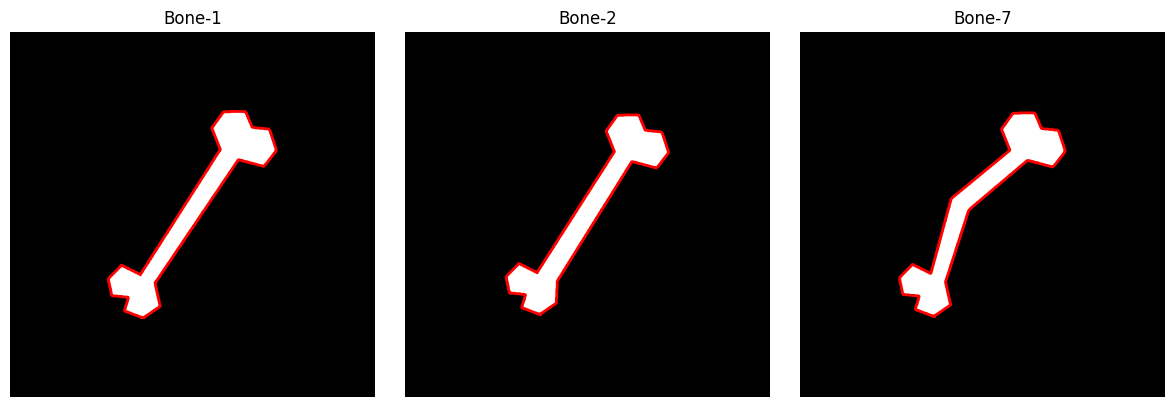

In [9]:
#!/usr/bin/env python3
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure

# ─── Boundary Extraction ───────────────────────────────────────────────────────
def extract_boundary(mask):
    """
    Given a 2D binary mask (0/1), return a list of (n_points×2)-arrays
    giving the (row, col) coordinates of each continuous contour at level=0.5.
    """
    return measure.find_contours(mask.astype(float), level=0.5)


def plot_contours_for_files(padded_dict, file_list, figsize_per=4):
    """
    Plot boundary contours for the exact filenames in `file_list`.

    Parameters
    ----------
    padded_dict : dict[str, 2D-array]
        Maps base_filename (no extension) → binary mask (0/1).
    file_list : list[str]
        Filenames (with or without .gif/.png extension) whose contours to plot.
    figsize_per : int
        Width (and height) per subplot in inches.
    """
    # Normalize file_list to base names
    bases = [os.path.splitext(os.path.basename(f))[0] for f in file_list]
    n = len(bases)
    plt.figure(figsize=(figsize_per * n, figsize_per))
    for i, base in enumerate(bases):
        if base not in padded_dict:
            raise ValueError(f"'{base}' not found in padded_dict (available: {list(padded_dict.keys())})")
        mask = padded_dict[base]
        contours = extract_boundary(mask)

        ax = plt.subplot(1, n, i + 1)
        ax.imshow(mask, cmap='gray')
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
        ax.set_title(base)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# ─── Main: Load Masks & Invoke Plotter ────────────────────────────────────────
if __name__ == '__main__':
    # 1) Load your preprocessed, square-padded masks from disk
    processed_dir = "processed"  # directory where masks were saved as .png
    padded_dict = {}
    for fname in os.listdir(processed_dir):
        if not fname.lower().endswith(".png"):
            continue
        base = os.path.splitext(fname)[0]
        img = Image.open(os.path.join(processed_dir, fname)).convert("L")
        mask = (np.array(img) > 127).astype(np.uint8)
        padded_dict[base] = mask

    # 2) Specify exactly which filenames to plot (GIF or PNG names both work)
    files_to_plot = [
        "Bone-1.gif",
        "Bone-2.gif",
        "Bone-7.gif",
        # you can also specify "bell-02.png", etc.
    ]

    # 3) Plot the boundary contours
    plot_contours_for_files(padded_dict, files_to_plot)


In [8]:
#!/usr/bin/env python3
import os
import numpy as np
from PIL import Image
from scipy.ndimage import label
from skimage import measure

# ─── Preprocessing Functions ──────────────────────────────────────────────────
def filter_to_largest_cc(img_array):
    """Return binary mask of the largest connected white component."""
    mask = img_array > 0
    labeled, num = label(mask, structure=np.ones((3,3)))
    if num < 1:
        return np.zeros_like(img_array, dtype=np.uint8)
    sizes = np.bincount(labeled.ravel())
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(np.uint8)


def normalize_cc_size(mask, target_area):
    """Scale mask so its white-pixel area ≈ target_area."""
    current = mask.sum()
    if current in (0, target_area):
        return mask
    scale = np.sqrt(target_area / current)
    h, w = mask.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    pil = Image.fromarray((mask * 255).astype(np.uint8))
    resized = pil.resize((new_w, new_h), resample=Image.BILINEAR)
    return (np.array(resized) > 127).astype(np.uint8)


def crop_to_shape(mask):
    """Crop mask tightly around its white pixels."""
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return mask
    r0, c0 = coords.min(axis=0)
    r1, c1 = coords.max(axis=0)
    return mask[r0:r1+1, c0:c1+1]


def pad_image_to_square(img, target_length):
    """Pad image to a centered square of side target_length."""
    h, w = img.shape
    pad_h = (target_length - h) // 2
    pad_w = (target_length - w) // 2
    out = np.zeros((target_length, target_length), dtype=np.uint8)
    out[pad_h:pad_h+h, pad_w:pad_w+w] = img
    return out

# ─── Contour Extraction & Simplicial Conversion ───────────────────────────────
def extract_boundary(mask):
    """
    Given a 2D binary mask (0/1), return a list of (Ni×2)-arrays
    of (row, col) coordinates of each contour at level=0.5.
    """
    return measure.find_contours(mask.astype(float), level=0.5)


def contours_to_simplicial(contours):
    """
    Convert a list of contours (from find_contours) into:
      - data:      list of (row, col) tuples for each vertex
      - simplices: list of [v1, v2] edges (1-based indices into data)
    """
    data = []
    simplices = []
    offset = 0
    for loop in contours:
        pts = [tuple(pt) for pt in loop]  # [(row, col), ...]
        data.extend(pts)
        N = len(pts)
        for j in range(N):
            v1 = offset + j     + 1
            v2 = offset + (j+1)%N + 1
            simplices.append([v1, v2])
        offset += N
    return data, simplices

# ─── Main Processing ─────────────────────────────────────────────────────────
if __name__ == '__main__':
    # 1) List all GIFs
    gif_files = [f for f in os.listdir('.') if f.lower().endswith('.gif')]
    if not gif_files:
        raise RuntimeError("No .gif files found in current directory.")

    # 2) Build raw masks (largest CC) and compute target area
    raw_masks = []
    for fname in gif_files:
        img = Image.open(fname)
        arr = np.array(img.convert('L')) if img.mode != 'L' else np.array(img)
        mask = filter_to_largest_cc(arr)
        raw_masks.append(mask)
    areas = [m.sum() for m in raw_masks]
    target_area = max(areas)

    # 3) Normalize size & crop
    processed_masks = []
    for mask in raw_masks:
        norm = normalize_cc_size(mask, target_area)
        cropped = crop_to_shape(norm)
        processed_masks.append(cropped)

    # 4) Pad to square
    max_dim = max(max(m.shape) for m in processed_masks)
    target_len = max_dim
    squared_masks = [pad_image_to_square(m, target_len) for m in processed_masks]

    # 5) Extract contours and convert to simplicial form
    contours_dict = {}
    for fname, mask in zip(gif_files, squared_masks):
        base = os.path.splitext(fname)[0]
        contours = extract_boundary(mask)
        data, simplices = contours_to_simplicial(contours)
        contours_dict[base] = {
            'data': data,         # list of (row, col) floats
            'simplices': simplices  # list of [v1, v2] int pairs
        }

    # Example: inspect one entry
    example_key = next(iter(contours_dict))
    print(f"Example '{example_key}':")
    print("  #vertices =", len(contours_dict[example_key]['data']))
    print("  #edges    =", len(contours_dict[example_key]['simplices']))


Example 'children-3':
  #vertices = 3755
  #edges    = 3755


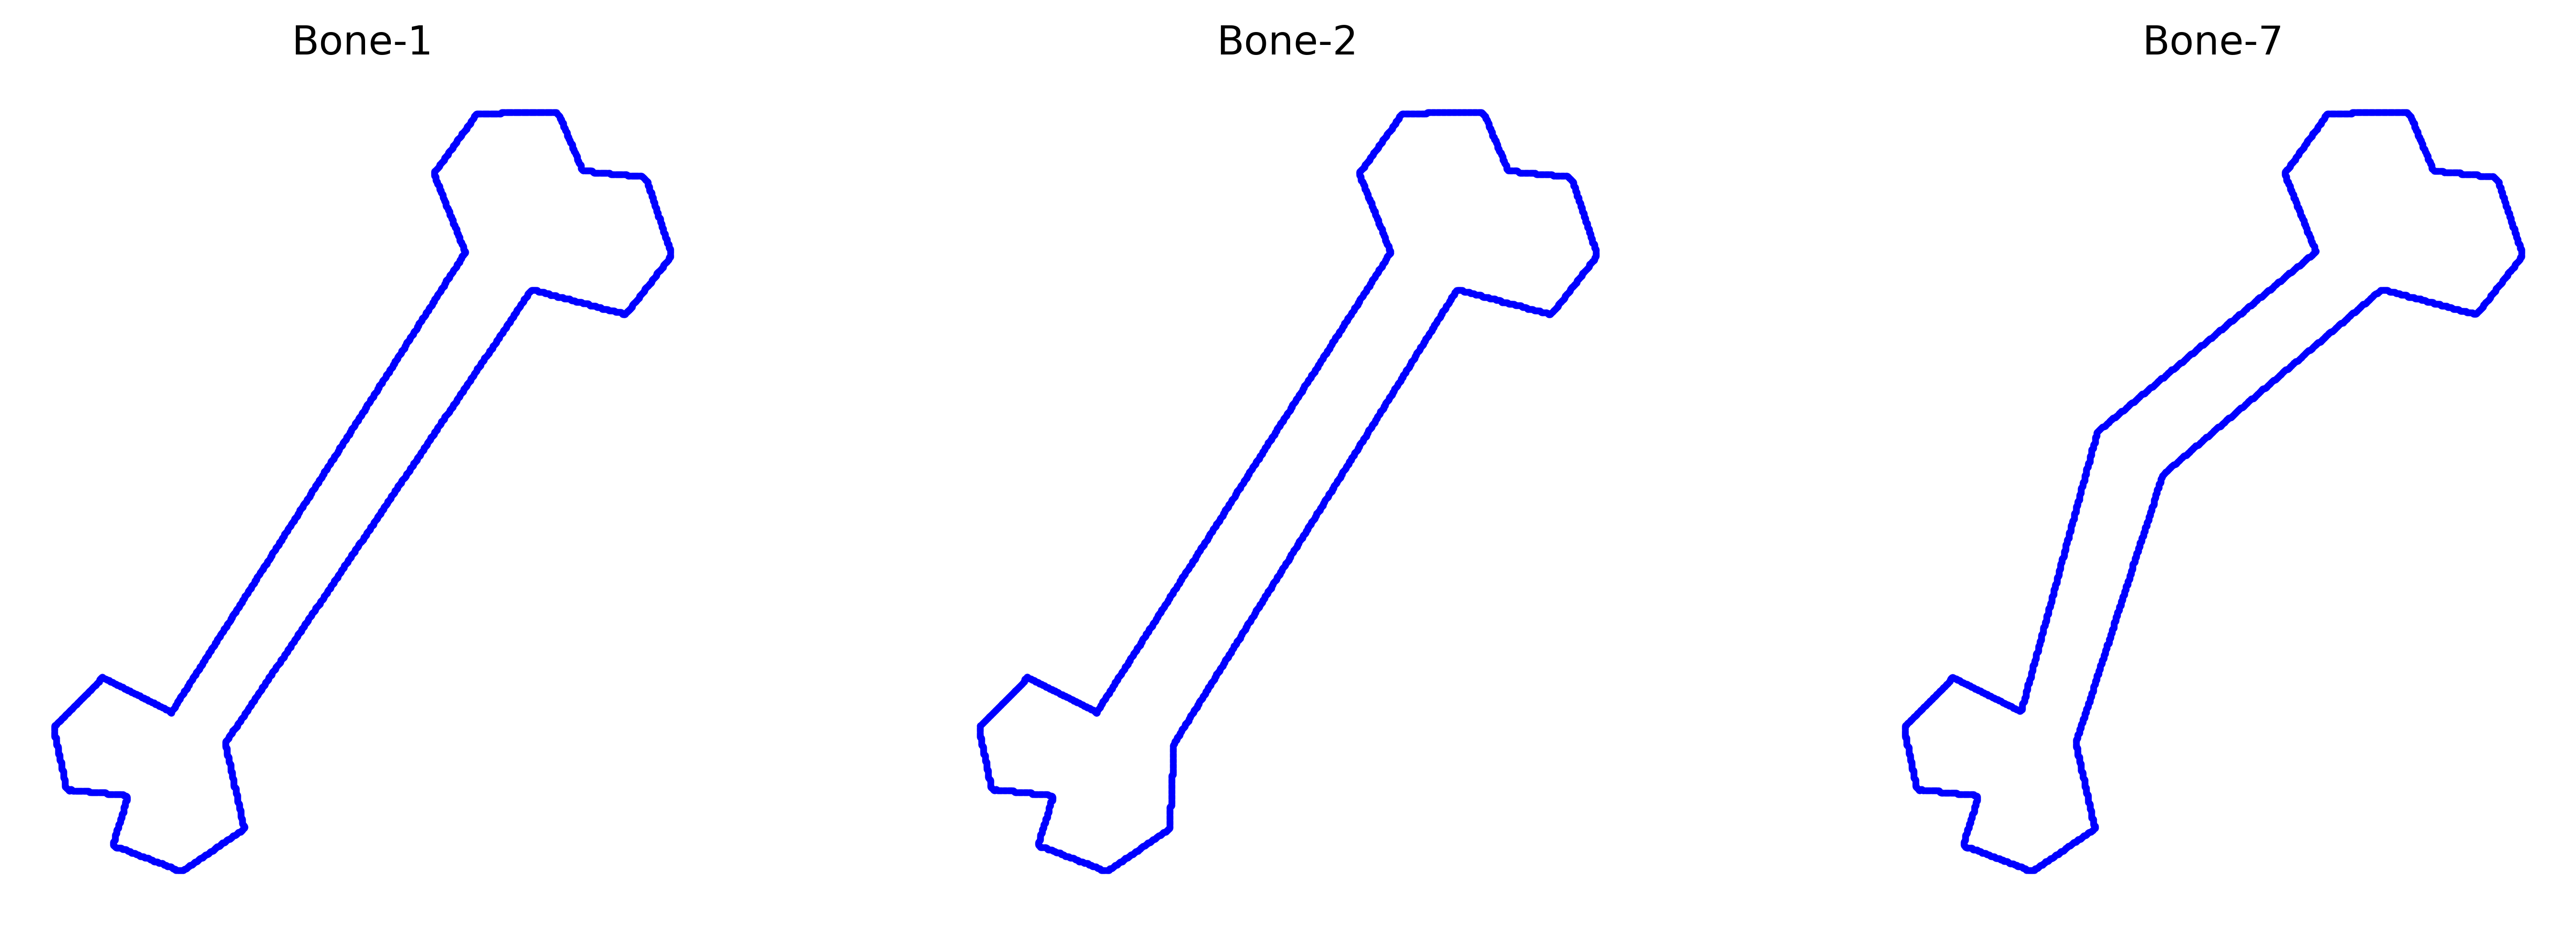

In [13]:
#!/usr/bin/env python3
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure

# ─── Contour → Simplicial Conversion (unchanged) ─────────────────────────────
def extract_boundary(mask):
    return measure.find_contours(mask.astype(float), level=0.5)

def contours_to_simplicial(contours):
    data, simplices = [], []
    offset = 0
    for loop in contours:
        pts = [tuple(pt) for pt in loop]
        data.extend(pts)
        N = len(pts)
        for j in range(N):
            v1 = offset + j     + 1
            v2 = offset + (j+1)%N + 1
            simplices.append([v1, v2])
        offset += N
    return data, simplices

# ─── High-DPI Plotting ───────────────────────────────────────────────────────
def plot_vertices_and_edges(padded_dict, file_list, figsize_per=4, dpi=200):
    """
    Plot vertices & edges of the contours for each filename, at higher DPI.

    Args:
      padded_dict: dict[base_filename→2D binary mask]
      file_list:   list of filenames (gif/png/just base) to plot
      figsize_per: width (and height) per subplot in inches
      dpi:         dots-per-inch for the figure
    """
    n = len(file_list)
    plt.figure(figsize=(figsize_per*n, figsize_per), dpi=dpi)
    for i, fname in enumerate(file_list):
        base = os.path.splitext(os.path.basename(fname))[0]
        if base not in padded_dict:
            raise ValueError(f"{base!r} not in padded_dict")
        mask = padded_dict[base]
        contours = extract_boundary(mask)
        data, simplices = contours_to_simplicial(contours)

        coords = np.array(data)
        rows, cols = coords[:,0], coords[:,1]

        ax = plt.subplot(1, n, i+1)
        ax.set_aspect('equal')
        ax.scatter(cols, rows, s=1, c='blue', alpha=0.6)
        # for v1, v2 in simplices:
        #     y1, x1 = data[v1-1]
        #     y2, x2 = data[v2-1]
        #     ax.plot([x1, x2], [y1, y2], '-', linewidth=1, c='black')

        ax.invert_yaxis()
        ax.set_title(base)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ─── Main: load masks & call high-DPI plot ──────────────────────────────────
if __name__ == '__main__':
    processed_dir = "processed"
    padded_dict = {}
    for fname in os.listdir(processed_dir):
        if not fname.lower().endswith('.png'):
            continue
        base = os.path.splitext(fname)[0]
        img = Image.open(os.path.join(processed_dir, fname)).convert('L')
        mask = (np.array(img) > 127).astype(np.uint8)
        padded_dict[base] = mask

    # pick whichever image bases you like:
    files_to_plot = ["Bone-1.gif", "Bone-2.gif", "Bone-7.gif"]

    # now call with higher DPI
    plot_vertices_and_edges(padded_dict, files_to_plot,
                            figsize_per=4, dpi=500)
